In [1]:
import numpy as np
import random
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable

In [2]:
from torchsummary import summary

In [6]:
class Actor(nn.Module):
  
    def __init__(self, state_dim, action_dim, max_action):
        super(Actor, self).__init__()
        self.max_action = max_action
        self.conv1 = conv_block(in_channels=1, out_channels=10)
        self.conv2 = conv_block(in_channels=10, out_channels=20)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = conv_block(in_channels=20, out_channels=30)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(1,1))
        
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(10, 1)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.maxpool1(x)
        x = self.conv3(x)
        x = self.maxpool2(x)
        x = self.conv4(x)
        x = self.gap(x)
        print(x.size())
        print(x.squeeze().size())
        x = self.linear(x.squeeze())
        x = self.max_action * F.tanh(x)
        return x



In [7]:
a=Actor(((100,1,100,100)),5,1)

NameError: name 'conv_block' is not defined

In [785]:
summary(Actor(((100,1,100,100)),5,1),(1,100,100))

torch.Size([2, 10, 1, 1])
torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 98, 98]             100
       BatchNorm2d-2           [-1, 10, 98, 98]              20
              ReLU-3           [-1, 10, 98, 98]               0
           Dropout-4           [-1, 10, 98, 98]               0
        conv_block-5           [-1, 10, 98, 98]               0
            Conv2d-6           [-1, 20, 96, 96]           1,820
       BatchNorm2d-7           [-1, 20, 96, 96]              40
              ReLU-8           [-1, 20, 96, 96]               0
           Dropout-9           [-1, 20, 96, 96]               0
       conv_block-10           [-1, 20, 96, 96]               0
        MaxPool2d-11           [-1, 20, 48, 48]               0
           Conv2d-12           [-1, 30, 46, 46]           5,430
      BatchNorm2d-13           [-1, 30, 46, 46]          

/home/ravil/miniconda3/envs/pytorch/lib/python3.7/site-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [775]:
class Critic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Critic, self).__init__()

        # critic 1
        self.conv1_a = conv_block(in_channels=1, out_channels=10)
        self.conv2_a = conv_block(in_channels=10, out_channels=20)
        self.maxpool1_a = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3_a = conv_block(in_channels=20, out_channels=30)
        self.maxpool2_a = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4_a = nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(1, 1))
        self.gap_a = nn.AvgPool2d(10)
        self.linear1_a = nn.Linear(10 + action_dim, 30)
        self.linear2_a = nn.Linear(30, 1)

        # critic 2
        self.conv1_b = conv_block(in_channels=1, out_channels=10)
        self.conv2_b = conv_block(in_channels=10, out_channels=20)
        self.maxpool1_b = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3_b = conv_block(in_channels=20, out_channels=30)
        self.maxpool2_b = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv4_b = nn.Conv2d(in_channels=30, out_channels=10, kernel_size=(1, 1))
        self.gap_b = nn.AvgPool2d(13)
        self.linear1_b = nn.Linear(10 + action_dim, 30)
        self.linear2_b = nn.Linear(30, 1)

    def forward(self, inp):
        x = self.conv1_a(inp)
        x = self.conv2_a(x)
        x = self.maxpool1_a(x)
        x = self.conv3_a(x)
        x = self.maxpool2_a(x)
        x = self.conv4_a(x)
        x = self.gap_a(x)
        x = x.squeeze()
        x = torch.cat([x, action], 1)
        x = self.linear1_a(x)
        x = self.linear1_b(x)

        y = self.conv1_b(inp)
        y = self.conv2_b(y)
        y = self.maxpool1_b(y)
        y = self.conv3_b(y)
        y = self.maxpool2_b(y)
        y = self.conv4_b(y)
        y = self.gap_b(y)
        y = y.squeeze()
        y = torch.cat([y, action], 1)
        y = self.linear1_b(y)
        y = self.linear1_b(y)

        return x, y

In [8]:


class ConvBlock(nn.Module):
    def __init__(
        self, in_channels, out_channels, kernel_size=(3, 3), dropout=0.1, **kwargs
    ):
        super(ConvBlock, self).__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                **kwargs,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout),
        )

    def forward(self, x):
        return self.convblock(x)


In [767]:
summary(Actor(((100,1,60,60)),5,1),(1,60,60))

torch.Size([2, 10, 1, 1])
torch.Size([2, 10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 58, 58]             100
       BatchNorm2d-2           [-1, 10, 58, 58]              20
              ReLU-3           [-1, 10, 58, 58]               0
           Dropout-4           [-1, 10, 58, 58]               0
        conv_block-5           [-1, 10, 58, 58]               0
            Conv2d-6           [-1, 20, 56, 56]           1,820
       BatchNorm2d-7           [-1, 20, 56, 56]              40
              ReLU-8           [-1, 20, 56, 56]               0
           Dropout-9           [-1, 20, 56, 56]               0
       conv_block-10           [-1, 20, 56, 56]               0
        MaxPool2d-11           [-1, 20, 28, 28]               0
           Conv2d-12           [-1, 30, 26, 26]           5,430
      BatchNorm2d-13           [-1, 30, 26, 26]          

In [139]:
summary(Critic(((1,60,60)),1),(1,60,60))

NameError: name 'action' is not defined

In [126]:
class Actor(nn.Module):
    def __init__(self, image_size, max_action):
        super(Actor, self).__init__()

        _, self.height, self.width = image_size
        self.max_action = max_action
        # self.set_dimensions((self.height,self.width))

        self.conv1 = conv_block(in_channels=3, out_channels=10)

        # self.set_dimensions((self.height//2,self.width//2))

        self.conv_s1 = conv_block(in_channels=10, out_channels=24, stride=2)

        self.conv2 = conv_block(in_channels=24, out_channels=16)

        # self.set_dimensions((self.height//2,self.width//2))

        self.conv_s2 = conv_block(in_channels=16, out_channels=24, stride=2)

        self.conv3 = conv_block(in_channels=24, out_channels=16, dropout=0.0)

        self.gap = nn.AvgPool2d(self.height)
        self.linear = nn.Linear(16, 1)

    def set_dimensions(self, output_dim):
        self.p_w, self.p_h = (1, 1)
        self.height, self.width = output_dim

    def forward(self, x):
        print(x.size())
        x = self.conv1(x)
        x = self.conv_s1(x)

        x = self.conv2(x)

        x = self.conv_s2(x)

        x = self.conv3(x)
        print(x.size())

        x = self.gap(x)
        print(x.size())
        x = self.linear(x.squeeze())
        print(x.size())

        return self.max_action * F.tanh(x)

In [130]:
summary(Actor(((3,60,60)),5),(3,60,60))

torch.Size([2, 3, 60, 60])
torch.Size([2, 16, 10, 10])
torch.Size([2, 16, 1, 1])
torch.Size([2, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 58, 58]             280
       BatchNorm2d-2           [-1, 10, 58, 58]              20
              ReLU-3           [-1, 10, 58, 58]               0
           Dropout-4           [-1, 10, 58, 58]               0
        conv_block-5           [-1, 10, 58, 58]               0
            Conv2d-6           [-1, 24, 28, 28]           2,184
       BatchNorm2d-7           [-1, 24, 28, 28]              48
              ReLU-8           [-1, 24, 28, 28]               0
           Dropout-9           [-1, 24, 28, 28]               0
       conv_block-10           [-1, 24, 28, 28]               0
           Conv2d-11           [-1, 16, 26, 26]           3,472
      BatchNorm2d-12           [-1, 16, 26, 26]              32
   

In [143]:
from PIL import Image as PILImage

In [401]:
arrow.thumbnail((20,10),PILImage.ANTIALIAS)

In [265]:
arrow.save("arrow_resized.png")

In [431]:
arrow = PILImage.open("./images/arrow.png")

In [432]:
# arrow = np.array(arrow)

In [435]:
arrow.size

(225, 225)

In [436]:
np.array(arrow)[3,4]

array([0, 0, 0, 0], dtype=uint8)

In [573]:
mask = PILImage.open("./images/mask.png").convert("L")

In [574]:
np.array(mask).shape

(1429, 660)

In [575]:
rotated = arrow.rotate(45)

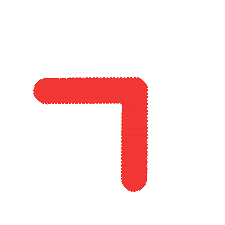

In [576]:
rotated

In [447]:
mask = np.array(mask)

In [448]:
x,y=715,330

In [449]:
mask_crop = mask[x-50:x+50,y-10:y+90]

In [450]:
mask_crop=PILImage.fromarray(mask_crop)

In [454]:
final1 = PILImage.new("RGB", mask_crop.size)
final1.paste(mask_crop, (0,0), mask_crop)
final1.paste(rotated, (100,100), rotated)

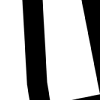

In [455]:
mask_crop

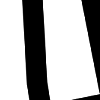

In [558]:
final1

In [749]:
def crop_image(x,y):
    mask = PILImage.open("./images/mask.png").convert("RGB")
    print(mask.size)
    arrow = PILImage.open("./images/arrow.png").convert("RGBA")
    arrow = arrow.resize((40,20))
    print(arrow.size)
    rotated = arrow.rotate(90)
    mask.paste(rotated,(int(x),int(y)),rotated)
    cropped_mask = mask.crop((x-30,y-100,x+170,y+100))
    return cropped_mask
#     rotated.show()
#     mask_crop = np.array(mask)[x-50:x+50,y-10:y+90]
#     print(mask_crop.shape)
#     mask_crop = PILImage.fromarray(mask_crop,"RGBA")
#     superimpose = PILImage.new("RGB", (100,100))
#     superimpose.show()
#     superimpose.paste(mask_crop, (0,0), mask_crop)
#     superimpose.paste(rotated, (x,y), rotated)

#     print()
#     mask_crop.paste(rotated,(0,0),rotated)
#     mask_crop.show()
#     superimpose.show()
#     superimpose = superimpose.convert("RGB")
#     superimpose.show()

In [750]:
mask.size

(660, 1429)

In [752]:
x=crop_image(600,500)

(660, 1429)
(40, 20)


In [754]:
# np.array(x).shape

(660, 1429)
(40, 20)


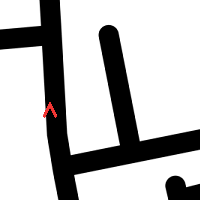

In [747]:
crop_image(660/2,1429/2)

In [708]:
x = np.array(img)

In [162]:
x.shape

(1429, 660)

In [172]:
y = x.reshape(1429,660,1)

In [173]:
y.shape

(1429, 660, 1)

In [718]:
a=10

In [728]:
def aa():
    print(a)
    b=a
    b=20
    print(b)


In [729]:
a

10

In [730]:
aa()

10
20


In [731]:
a

10

In [734]:
m1=mask.copy()

In [755]:
a=1

In [756]:
a+=-1

In [757]:
a

0

In [759]:
a=np.array(mask)